# Monte Carlo Methods I: Random Numbers and Random Walk

Computational physics often begins with the notion that classical equations can perfectly predict the evolution of a system if one knows the initial conditions precisely.
However, many real-world processes involve an inherent level of randomness or produce outcomes so sensitive to initial conditions that they effectively appear random.
Radioactive decay, governed by quantum mechanics, is an example of truly non-deterministic behavior, whereas chaotic classical systems like the three-body problem can exhibit sensitive dependence on initial conditions.
As a result, introducing randomness into our computational methods is not only natural for modeling genuinely stochastic systems but also highly advantageous even in deterministic settings.

Monte Carlo methods, which rely on random sampling to estimate quantities of interest, illustrate how such randomness can be leveraged as a powerful tool in numerical analysis.
The phrase "Monte Carlo" alludes to the famous casino district in Monaco, highlighting the essence of "gambling" with random draws to tackle challenging problems.
Since their popularization in mid-twentieth-century nuclear research, Monte Carlo algorithms have found widespread use in evaluating high-dimensional integrals, simulating physical processes in statistical mechanics, performing error analysis in data-driven fields, and more.

![Monte Carlo](https://upload.wikimedia.org/wikipedia/commons/1/1b/Monaco_pano.jpg)

Although real physical systems may exhibit genuine randomness (as seen in quantum events), computer algorithms generate numbers through deterministic procedures.
These "pseudo-random" sequences are designed to mimic statistical randomness but are entirely reproducible given a specific initial seed.
In practice, a well-crafted pseudo-random number generator can satisfy the statistical requirements of scientific simulations, especially if it has a sufficiently large period and low correlations across many dimensions. Modern generators such as the Mersenne Twister, PCG, and Xorshift provide excellent performance in these regards, far surpassing the simpler linear congruential generators of older programming standards.

## Pseudo-Random Number Generators (PRNGs)

In computational physics, random draws are often produced by deterministic algorithms called pseudo-random number generators.
These generators start from an internal seed and use a mathematical rule to transform it repeatedly, producing an output sequence that ideally appears random.
Although each sequence is entirely predictable if one knows the seed and the algorithm, a good generator will avoid obvious patterns and pass stringent statistical tests.

### Congruential Generators

Early implementations of pseudo-random number generators were often based on linear congruential generators. The simplest form of this approach looks something like
\begin{align}
x_{n+1} = (a x_n + c) \mathrm{\ mod\ } m,
\end{align}
where $x_n$ represents the state at step $n$, and $a$, $c$, and $m$ are carefully chosen integers.

In [1]:
# In order to understand the concept of a random number generator, let's implement one ourself.

mynext = 1

def myrand(): # NOT RECOMMENDED for real application.
    global mynext # by default, python does not recognize variable in a different scope.
    mynext = mynext * 1103515245 + 12345
    return (mynext//65536) % 32768

# This random number generator would generate integers in the domain [0, 32768).
# This random is usually provided to user by

MYRAND_MAX = 32768-1

# There are reasons for choosing the strange constants.  Take a look at
#     https://en.wikipedia.org/wiki/Linear_congruential_generator
# if you are interested.

In [2]:
# Now, every time we run `rand()`, we will get a different number

myrand()

16838

In [3]:
# We may just print many of them at the same time:

Rs = [myrand() for i in range(100)]
print(Rs)

[5758, 10113, 17515, 31051, 5627, 23010, 7419, 16212, 4086, 2749, 12767, 9084, 12060, 32225, 17543, 25089, 21183, 25137, 25566, 26966, 4978, 20495, 10311, 11367, 30054, 17031, 13145, 19882, 25736, 30524, 28505, 28394, 22102, 24851, 19067, 12754, 11653, 6561, 27096, 13628, 15188, 32085, 4143, 6967, 31406, 24165, 13403, 25562, 24834, 31353, 920, 10444, 24803, 7962, 19318, 1422, 31327, 10457, 1945, 14479, 29983, 18751, 3894, 18670, 8259, 16248, 7757, 15629, 13306, 28606, 13990, 11738, 12516, 1414, 5262, 17116, 22825, 3181, 13134, 25343, 8022, 11233, 7536, 9760, 9979, 29071, 1201, 21336, 13061, 22160, 24005, 30729, 7644, 27475, 31693, 25514, 14139, 22088, 26521, 5202]


In [4]:
# Sometime it is useful to make sure your random number sequence remains the same.
# In our case, you may notice that we can simply reset the `mynext` global variable to reset the sequence.
# The value you put in `mynext` is often called the "seed".

print('The following two lists are not the same:')
print([myrand() for i in range(10)])
print([myrand() for i in range(10)])

print('We may ensure that they are the same by "seeding" the random number generator with a fixed value:')

mynext = 1234
print([myrand() for i in range(10)])

mynext = 1234
print([myrand() for i in range(10)])

The following two lists are not the same:
[9171, 4434, 28317, 24582, 6815, 4586, 9653, 26306, 7174, 18451]
[23448, 6473, 32434, 8193, 14110, 24748, 28210, 29320, 32049, 12956]
We may ensure that they are the same by "seeding" the random number generator with a fixed value:
[3558, 1960, 1307, 12725, 23832, 32319, 26039, 18587, 12983, 14234]
[3558, 1960, 1307, 12725, 23832, 32319, 26039, 18587, 12983, 14234]


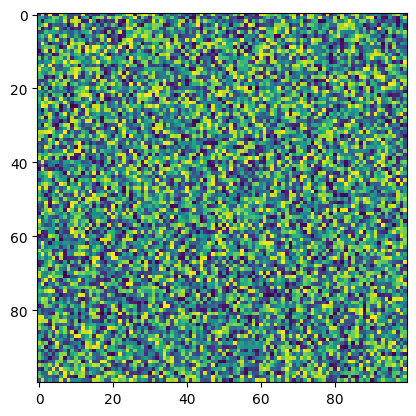

In [5]:
# We may even plot the random numbers

from matplotlib import pyplot as plt

ll = [[myrand() for i in range(100)] for j in range(100)]
plt.imshow(ll)

This random number generator is very simple and is the *sample* implementation in many ANSI C libraries!
However, because how the standard was written, this create a lot problems.
* The standard only require `RAND_MAX` be at least 32767.
  If one want to evulate 1e6 points (which is pretty small, as we will see below), you will actually be evaluating the same 32768 points 30 times each!
* Some implementation "tried" to imporve the algorithm, e.g., swapping the lower and higher bytes.
  But these tricks sometime ruins the generator!
* Integrating high-dimension space is an important application of Monte Carlo methods.
  However, the congruential generators create correlation in k-space.

When programming in Python, we often take advantage of the built-in random module or NumPy's random subpackage, both of which default to high-quality generators (the Mersenne Twister for Python's default, and similarly robust methods in NumPy).
We can seed these generators manually to ensure reproducible research, or we may allow them to seed automatically for convenience.
While these generators generally suffice for undergraduate-level simulations, more intricate studies---particularly those involving very large datasets or extremely sensitive measurements---may require advanced or specialized libraries for best results.

### Python's Random Number Library

We start by trying python's random number library.
It is implemented in a very traditional way, which relies on a global seed and "procedure" programming style:

In [6]:
import random as pyr

print(pyr)
pyr.seed(0)

print(pyr.random())           # return a random float in the range [0,1)
print(pyr.randrange(100))     # return a random int in the range [0, stop)
print(pyr.randint(a=0,b=99))  # return a random int in the range [a, b+1); alias for randrange(a, b+1)

<module 'random' from '/usr/local/python/3.12.1/lib/python3.12/random.py'>
0.8444218515250481
97
53


### Numpy's Random Number Module

Next, we  Let's now try numpy's random number module.
It can also be used with a global seed.
However, for modern applications, it is often better to use object oriented (OO) approach, where the random number generator's state is stored in an object.
This allows one to create multiple random number generators in a single application.

In [7]:
import numpy as np

npr = np.random.default_rng(seed=0)
print(npr)

print(npr.random())                               # return a random float in the range [0,1)
print(npr.integers(low=0,high=99))                # return a random int in the range [low, high)
print(npr.integers(low=0,high=99,endpoint=True))  # return a random int in the range [low, high] = [low, high+1) for int

Generator(PCG64)
0.6369616873214543
50
26


### JAX's Random Number Module

Although numpy's OO approach is already an improvement, it can create ugly bugs for parallel algorithm.
Accelerated by GPU, JAX takes a functional programming apporach.
The random number generator's state is stored in a "key" object.
The key is then passed into a jax function to generate random numbers.

In [8]:
from jax import random as jxr

key = jxr.key(seed=0)
print(key)

print(jxr.uniform(key))                           # return a random float in the range [0,1)
print(jxr.randint(key, (), minval=0, maxval=99))  # return a random int in the range [minval, maxval)

Array((), dtype=key<fry>) overlaying:
[0 0]
0.947667
85


Note that, unlike `numpy`, the same key always return the same random number:

In [9]:
print(jxr.uniform(key))
print(jxr.uniform(key))
print(jxr.uniform(key))
print(jxr.uniform(key))

0.947667
0.947667
0.947667
0.947667


If we need a new random number, we can use `split()` to generate new subkeys:

In [10]:
key, subkey = jxr.split(key)
print(key)
print(subkey)
print(jxr.uniform(subkey))
print(jxr.uniform(subkey))

Array((), dtype=key<fry>) overlaying:
[1797259609 2579123966]
Array((), dtype=key<fry>) overlaying:
[ 928981903 3453687069]
0.0072938204
0.0072938204


In [11]:
key, subkey = jxr.split(key)
print(key)
print(subkey)
print(jxr.uniform(subkey))
print(jxr.uniform(subkey))

Array((), dtype=key<fry>) overlaying:
[4165894930  804218099]
Array((), dtype=key<fry>) overlaying:
[1353695780 2116000888]
0.104290366
0.104290366


### Array of Random Numbers

For both numpy and JAX, it is simple to create an array of random numbers:

In [12]:
ll2 = npr.random(size=(100,100))
ll3 = jxr.uniform(key, shape=(100,100))

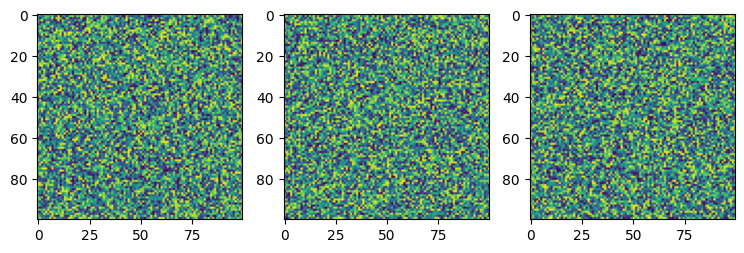

In [13]:
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9,3))
ax0.imshow(ll)
ax1.imshow(ll2)
ax2.imshow(ll3)

## Drawing Random Numbers from Distributions

The random numbers we generated so far, including the ones from our own congruential generator, can be seen as a "random variable" draw from a **uniform distribution**.

(array([100.,  85.,  97.,  99., 103.,  94., 111.,  90., 117., 104.]),
 array([2.86308707e-04, 1.00158921e-01, 2.00031533e-01, 2.99904145e-01,
        3.99776757e-01, 4.99649369e-01, 5.99521981e-01, 6.99394593e-01,
        7.99267205e-01, 8.99139817e-01, 9.99012429e-01]),
 <BarContainer object of 10 artists>)

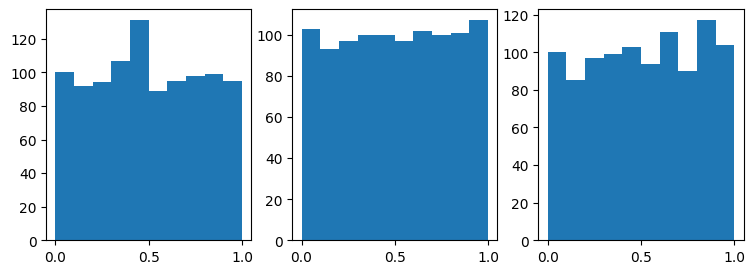

In [14]:
# We may plot the results of these random number generators

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9,3))
ax0.hist(npr.random(1000))
ax1.hist(npr.random(1000))
ax2.hist(npr.random(1000))

However, many physical phenomena and statistical models require samples from specific probability distributions.
These range from exponential and Poisson processes in radioactive decay to Maxwell–Boltzmann velocity distributions in statistical mechanics.
A variety of sampling or transformation techniques exist to convert uniform random numbers into draws from virtually any target distribution.

### Inverse Transform Method

The inverse transform method is a basic technique for generating random numbers drawn from a specified distribution.
Suppose we have a continuous random variable $X$ with probability density function $f(x)$ and corresponding cumulative distribution function $F(x)$.
The method begins by noting that if $U$ is a uniform random variable on the interval $[0, 1)$, then the random variable $X = F^{-1}(U)$ follows the distribution described by $f(x)$.
In other words, the inverse of the CDF effectively maps uniform deviates to the desired target distribution.

To illustrate the procedure, consider the exponential distribution with a rate parameter $\lambda$.
Its probability density function is
\begin{align}
f(x) = \lambda\,e^{-\lambda x}, \quad x \ge 0,
\end{align}
and the cumulative distribution function is
\begin{align}
F(x) = 1 - e^{-\lambda x}.
\end{align}
Because $F(x)$ is invertible, the inverse function is
\begin{align}
F^{-1}(u) = -\frac{1}{\lambda} \ln\bigl(1 - u\bigr).
\end{align}
Thus, if $u$ is drawn uniformly from $[0,1)$, then
\begin{align}
x = -\frac{1}{\lambda}\,\ln\bigl(1 - u\bigr)
\end{align}
is an exponentially distributed random variable with parameter $\lambda$.
One may equivalently use $\ln(u)$ instead of $\ln(1 - u)$ since $u$ is uniform over $[0,1)$.

In [15]:
def inverse(u, lmbda, N=1000):
    return -np.log(1 - u) / lmbda

In [16]:
# Parameters:
lmbda = 1.0
N     = 10000

# Generate samples via our inverse transform function:
u = np.random.rand(N)
x = inverse(u, lmbda)

# Generate samples via NumPy's built-in exponential:
x_np = np.random.exponential(scale=1/lmbda, size=N)

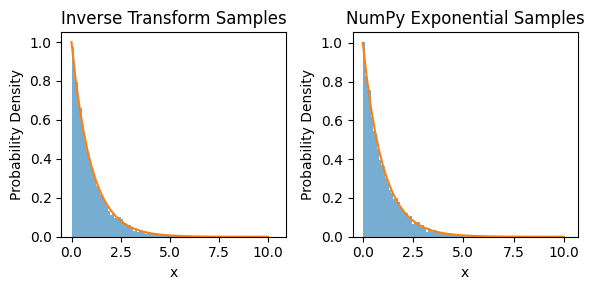

In [17]:
# Plot histograms for comparison:
X = np.linspace(0, 10)
Y = lmbda * np.exp(-lmbda * X)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3))

ax0.hist(x,   bins=100, density=True, alpha=0.6, label='Inverse Transform')
ax0.plot(X, Y)
ax0.set_title('Inverse Transform Samples')
ax0.set_xlabel('x')
ax0.set_ylabel('Probability Density')

ax1.hist(x_np, bins=100, density=True, alpha=0.6, label='NumPy Exponential')
ax1.plot(X, Y)
ax1.set_title('NumPy Exponential Samples')
ax1.set_xlabel('x')
ax1.set_ylabel('Probability Density')

fig.tight_layout()

### Rejection Method

Sometimes, we need to sample from a probability distribution whose cumulative distribution function is difficult or impossible to invert analytically.
In these cases, the rejection method (also called the acceptance–rejection method) provides a flexible alternative.
The key is to find a simple "proposal" distribution that we can easily sample from but that encloses the shape of our target distribution.
If we sample points under the proposal distribution and then reject those that would exceed the desired probability density, the remaining accepted points follow the intended target distribution.

To set up the rejection method, we need three main ingredients:

1. A probability density function $f(x)$ for the target distribution, defined on some interval or possibly $\mathbb{R}$.
2. A proposal distribution $g(x)$ that we can sample from easily (e.g., a uniform or Gaussian), along with a constant $C$ such that
   \begin{align}
   f(x) \le C\,g(x) \quad \text{for all valid }x.
   \end{align}
   This inequality ensures the proposal distribution "covers" or "bounds" the entire shape of $f(x)$.
4. A procedure to accept or reject each random draw based on how likely it is to come from $f(x)$.

The algorithm proceeds as follows:
1. Generate a random value $X$ according to the proposal distribution $g(x)$.
2. Generate a uniform random number $U \in [0,1)$.
3. Accept $X$ if
   \begin{align}
   U \le \frac{f(X)}{C\,g(X)},
   \end{align}
   otherwise reject $X$ and repeat.

Although conceptually simple, the rejection method's efficiency depends on how well the proposal distribution and scaling factor $C$ approximate the shape of $f(x)$.
A poorly chosen $g(x)$ or a large $C$ can cause excessive rejections, slowing the simulation.
On the other hand, almost any properly bounded PDF $f(x)$ is amenable to the rejection method, making it valuable for distributions that are hard to invert analytically.

Below is an example using a bimodal distribution with two Gaussian "peaks" on the interval [0,5]:
\begin{align}
f(x) = \exp\Bigl(-\frac{(x-1.5)^2}{0.1}\Bigr) \;+\; \exp\!\Bigl(-\frac{(x-3.5)^2}{0.1}\Bigr),
\quad
x \in [0,5],
\end{align}
and treat values outside $[0,5]$ as zero.
We will numerically find the normalization constant $Z$ so that
\begin{align}
f(x) \;=\;\frac{f(x)}{Z}
\end{align}
becomes a proper PDF.
As our proposal distribution, we will use a uniform $\text{Uniform}(0,5)$, whose PDF is $g(x)=\frac{1}{5}$ for $0 \le x \le 5$.
Finally, we will pick $C$ so that $f(x) \le C\,g(x)$ holds for all $x\in[0,5]$.

In [18]:
# Define the unnormalized target PDF (bimodal).
def bimodal_unnorm(x):
    if x < 0 or x > 5:
        return 0.0
    # Two Gaussian "lumps" centered at 1.5 and 3.5
    return np.exp(-(x - 1.5)**2 / 0.1) + np.exp(-(x - 3.5)**2 / 0.1)

In [19]:
# Numerically compute the normalization constant Z
def norm(num_points=10001):
    xs = np.linspace(0, 5, num_points)
    vals = [bimodal_unnorm(x) for x in xs]
    # Use the trapezoidal rule to approximate the integral
    return np.trapezoid(vals, xs)

Z = norm()
print(f"Normalization constant Z = {Z:.4f}")

Normalization constant Z = 1.1210


In [20]:
# Compute the maximum of f(x) so we can choose C*g(x) appropriately
def bimodal_pdf(x):
    return bimodal_unnorm(x) / Z

In [21]:
xs = np.linspace(0, 5, 10001)
fs = np.array([bimodal_pdf(x) for x in xs])

maxf = max(fs)
print(f"Max of bimodal PDF on [0,5] = {maxf:.4f}")

Max of bimodal PDF on [0,5] = 0.8921


In [22]:
# Our proposal is uniform(0,5), so g(x) = 1/5, 0 <= x <= 5
# We need C so that f(x) <= C*g(x) = C*(1/5).
# The maximum of f(x)/(1/5) = 5*maxf.  We can set C = 5*maxf.

C = 5 * maxf
print(f"Chosen C = {C:.4f}")

Chosen C = 4.4603


Acceptance ratio: 0.22


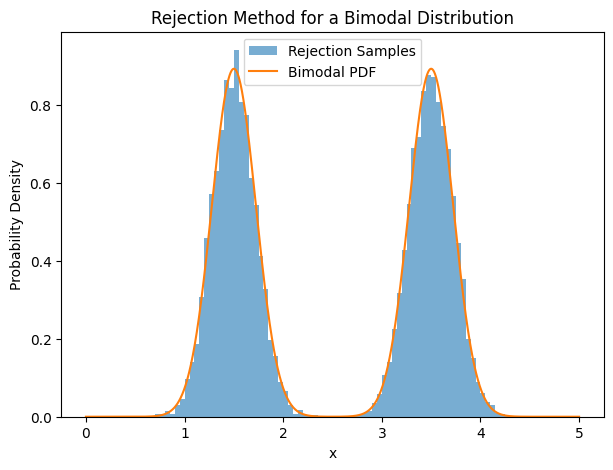

In [23]:
# Rejection sampling
def bimodal_rejection(n=10000):
    samples = []
    n_draws = 0
    while len(samples) < n:
        # Step 1: draw from proposal Uniform(0,5)
        x_prop = 5 * np.random.rand()
        
        # Step 2: draw a uniform U in [0,1)
        U = np.random.rand()
        
        # Step 3: accept/reject
        # Accept if U <= f(x_prop) / (C*g(x_prop)) = f(x_prop) / (C*(1/5)) = [5*f(x_prop)] / C
        if U <= (5 * bimodal_pdf(x_prop) / C):
            samples.append(x_prop)
        n_draws += 1
    
    acc_ratio = n / n_draws
    return np.array(samples), acc_ratio

# Generate samples
N = 10000
samples, acc_ratio = bimodal_rejection(N)
print(f"Acceptance ratio: {acc_ratio:.2f}")

# 5. Plot the results
plt.figure(figsize=(7,5))
plt.hist(samples, bins=100, range=(0,5), density=True, alpha=0.6, label='Rejection Samples')

plt.plot(xs, fs, label='Bimodal PDF')
plt.title('Rejection Method for a Bimodal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

### Generating Gaussian Distributions with Box–Muller Transform

Many physical processes often assume that noise or fluctuations follow a Gaussian (normal) distribution.
While Python (and many other languages) has built-in functions to generate normally distributed random numbers, it is informative to see how these values can be constructed directly from uniform deviates.
The Box–Muller transform is a classical algorithm to achieve this.

The Box-Muller transform relies on generating two independent standard normal variables $(Z_1, Z_2)$ from two independent uniform variables $(U_1, U_2)$ on the interval $[0,1)$.
The key insight is to consider a point drawn uniformly inside the unit square $(U_1,U_2)$ and map it to polar coordinates to produce values in the unit circle.
The derivation in brief:
1. Generate $U_1, U_2 \sim \text{Uniform}(0,1)$.
2. Let
   \begin{align}
   R = \sqrt{-2 \ln(U_1)}, \quad \Theta = 2\pi U_2.
   \end{align}
3. Define
   \begin{align}
   Z_1 = R \cos(\Theta), \quad Z_2 = R \sin(\Theta).
   \end{align}

These two variables $(Z_1, Z_2)$ are then independent and each follows $\mathcal{N}(0,1)$, i.e., a standard normal distribution.

The factor $\sqrt{-2 \ln(U_1)}$ corresponds to sampling a radial distance from a 2D exponential distribution that matches the Gaussian shape in polar coordinates, while $2\pi U_2$ selects a random angle uniformly.

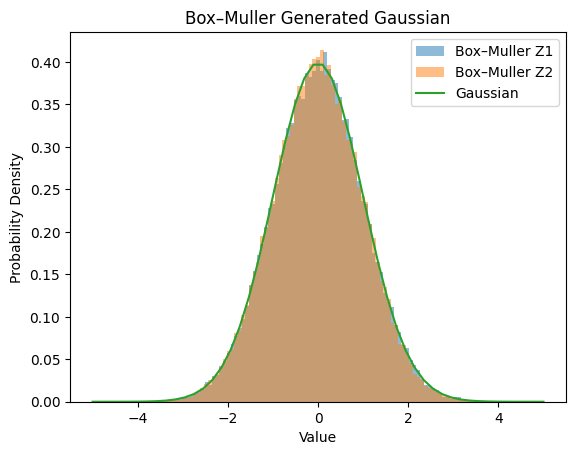

In [24]:
def box_muller(n_samples=10000):
    # U1, U2 are uniform(0,1)
    U1 = np.random.rand(n_samples)
    U2 = np.random.rand(n_samples)
    
    # Apply the Box–Muller formulas
    R = np.sqrt(-2.0 * np.log(U1))
    Theta = 2.0 * np.pi * U2
    
    Z1 = R * np.cos(Theta)
    Z2 = R * np.sin(Theta)
    
    return Z1, Z2

# Let's generate samples and plot their distribution:
Z1, Z2 = box_muller(n_samples=50000)  # 50k samples

X = np.linspace(-5, 5)
Y = np.exp(-X*X/2) / np.sqrt(2 * np.pi)

plt.hist(Z1, bins=100, density=True, alpha=0.5, label='Box–Muller Z1')
plt.hist(Z2, bins=100, density=True, alpha=0.5, label='Box–Muller Z2')
plt.plot(X, Y, label='Gaussian')
plt.title('Box–Muller Generated Gaussian')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

## Random Walk

Random walk is the minimal model to understand diffusion, Brownian motion, and a host of other physical processes that involve randomness.
The basic idea is that a particle (or person, in the "drunkard's walk" analogy) takes discrete steps in one dimension, moving either left or right with equal probability.
Over many steps, the trajectory becomes a record of these random increments.
In physics, random walks underlie the theoretical description of diffusion: particles jitter around in a fluid or gas, moving unpredictably due to collisions.
Mathematically, random walks also illustrate many foundational stochastic concepts, including how deviations grow with time and why the distribution of positions tends to be bell-shaped over many steps.

### Physical and Mathematical Background

Imagine a person standing at position $x = 0$.
At each time step, the person flips a fair coin:
* If the coin is heads, they step one unit to the left (+1 if we define left as the positive direction, or -1 if we define left as negative).
* If the coin is tails, they step one unit in the opposite direction.
Over $n$ steps, each move is chosen with probability $1/2$.
Because these steps are independent, the expected value of the person's position remains zero, but the spread or standard deviation of the position grows with the square root of time $(\sigma \propto \sqrt{n})$.
This is a fundamental result related to diffusion and the Central Limit Theorem.

Key quantitites for random walk are:
* Mean (average) displacement: $\langle X_n \rangle$.
  For an unbiased random walk, this remains zero.
* Root mean square (rms) displacement: $\sqrt{\langle X_n^2 \rangle}$.
  This value grows like $\sqrt{n}$, which explains why random walkers gradually drift away from the origin over time.

As $n$ becomes large, if we rescale by $\Delta x$ and $\Delta t$, the random walk converges to the diffusion equation in the continuum limit.
In one dimension, the diffusion equation is
\begin{align}
\frac{\partial \rho}{\partial t} = D \frac{\partial^2 \rho}{\partial x^2},
\end{align}
where $D$ is the diffusion coefficient.
Physically, this underlies processes like heat conduction and Brownian motion of particles in a fluid, as we learned in solving the heat equation in numerical linear algebra.

### Python Implementation

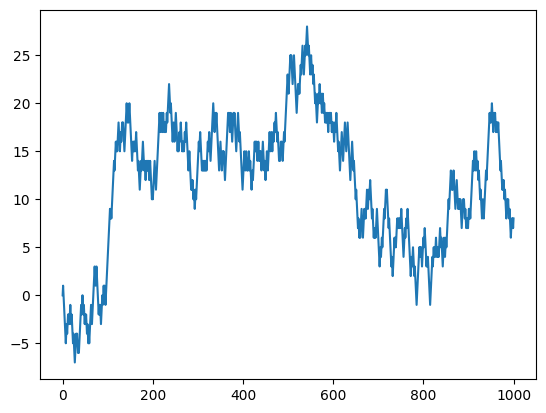

In [25]:
# Let's setup random walk in the following way:

T = range(1000+1)
X = [0] # initial position

for t in T[1:]:
    last = X[-1]            # last position
    r    = pyr.randint(0,1) # we generate 0 or 1 randomly
    if r == 0:              # depending on r, we step left or right
        curr = last + 1
    else:
        curr = last - 1
    X.append(curr)          # append the current position to the list X

# We may plot this random walk
plt.plot(T, X)
plt.show() # optional if you use Jupyter Notebook

Awesome!
But in order to find out how random walk behave statistically, we want to be able to run many simulations!

Hence, it is convenient to define a function:

In [26]:
def randomwalk(n_steps=1000):
    X = [0] # initial position
    
    for t in range(n_steps):
        last = X[-1]            # last position
        r    = pyr.randint(0,1) # we generate 0 or 1 randomly
        if r == 0:              # depending on r, we step left or right
            curr = last + 1
        else:
            curr = last - 1    
        X.append(curr)          # append the current position to the list X
        
    return X                    # return the result

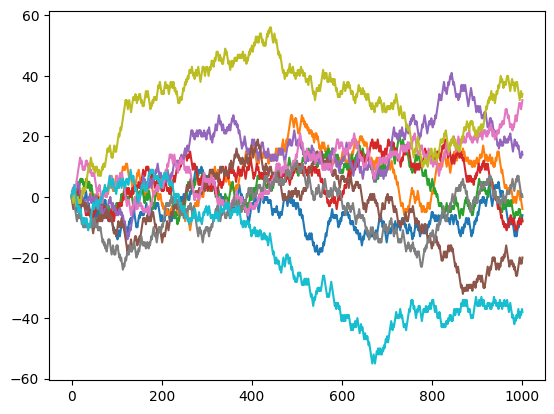

In [27]:
# And we can use this function in another loop.
for i in range(10):
    plt.plot(randomwalk())

We may now ask how far away the person would walk depending on the number of stpes.

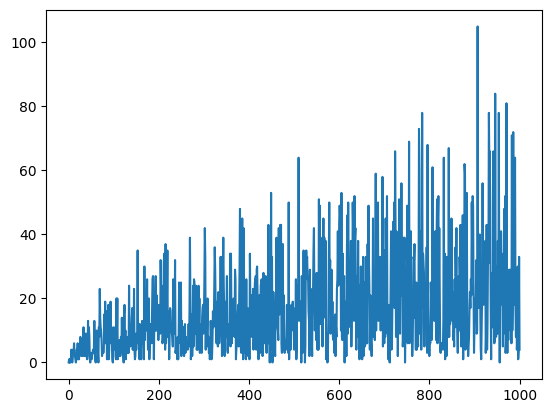

In [28]:
absX = []
for t in T:
    X = randomwalk(t)
    absX.append(abs(X[-1]))

plt.plot(absX)

Clearly, the distance gets farther when the number of steps increase.
But this figure is too noisy to read off the dependency.

There are multiple ways to make the above figure less noisy.
One way is to simply do multiple numerical experiments for the same number of steps.
And obtain the average distance.

We can also plot this in log-log scale and compare it with the law of diffusion $D \sim \sqrt{T}$.

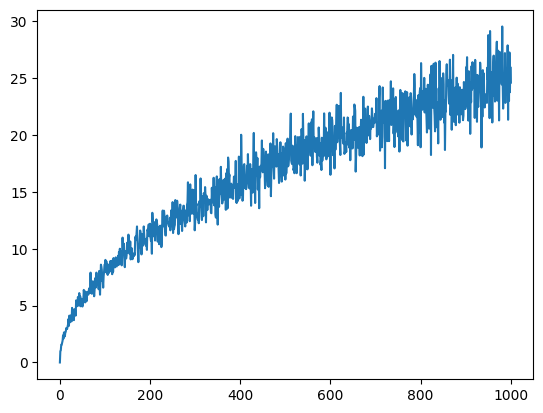

In [29]:
n_trials = 100
X = []
for t in T:
    S = 0
    for _ in range(n_trials):
        S += abs(randomwalk(t)[-1])
    X.append(S / n_trials)
    
plt.plot(X)

We can also plot this in log-log scale and compare it with the law of diffusion $D ~ sqrt(T)$.

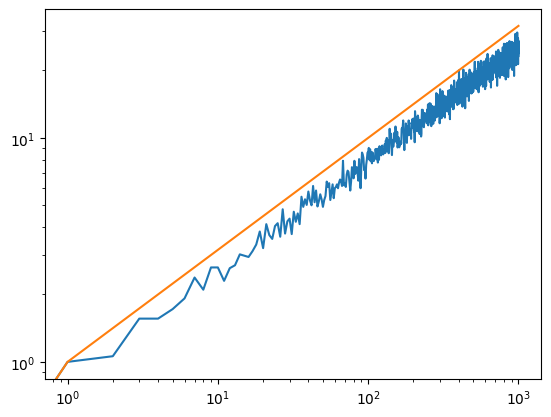

In [30]:
plt.loglog(T, X)
plt.plot(T, [t**0.5 for t in T])

## 2D Random Walk and Brownian Motion

Random walks extend naturally from one dimension to two (or more) dimensions.
In two dimensions, we can imagine a particle in a plane taking steps in $x$ and $y$ directions.
Each step can be independent in both axes, or it can be chosen randomly in angle and magnitude.
This extension provides a convenient model for Brownian motion, a phenomenon describing how small particles suspended in a fluid move erratically due to collisions with the fluid's molecules.
Albert Einstein's 1905 paper on Brownian motion was crucial in confirming the atomic theory of matter, demonstrating how random thermal collisions produce observable diffusion.

![Brownian motion](https://upload.wikimedia.org/wikipedia/commons/c/c2/Brownian_motion_large.gif)

### Physical Background

In 2D, the particle's position can be represented by $(X_n, Y_n)$.
For an unbiased random walk on a square grid, you can think of each step as adding either $\pm 1$ to $X_n$ and/or $Y_n$, chosen with equal probabilities.
Alternatively, you can treat each dimension as a separate 1D random walk.
Over many steps, we expect the displacement in $x$ and $y$ to follow the same $\sqrt{n}$ scaling we saw in 1D, but combined in quadrature:
\begin{align}
r_n = \sqrt{X_n^2 + Y_n^2} \quad \text{scales like} \quad \sqrt{2n},
\end{align}
if each dimension receives a $\pm 1$ step with probability $1/2$.
More generally, if the step length is some constant $\delta$, the mean-squared displacement after $n$ steps is proportional to $n$.
This is a major result of diffusion in two dimensions.

## Python Implementation

The simplest model of Brownian motion is simply a two-dimension random walk:

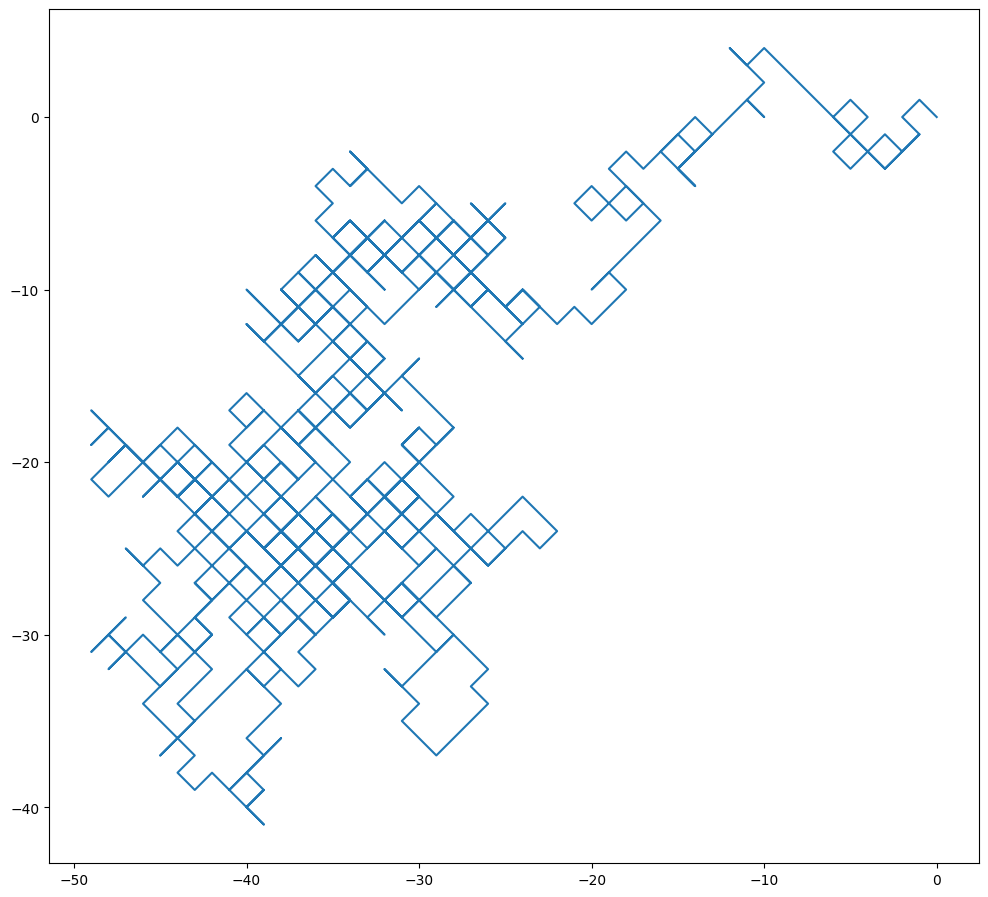

In [31]:
X = randomwalk()
Y = randomwalk()

plt.figure(figsize=(12,12))
plt.plot(X, Y)
plt.gca().set_aspect('equal')

The resulting plot looks slightly funny because random walk forces x and y both to move at exactly one step.
The final outcome is that the particle can only move in diagonal directions.

Nevertheless, this artifact becomes irrelevant when we model random walk for many many more steps.

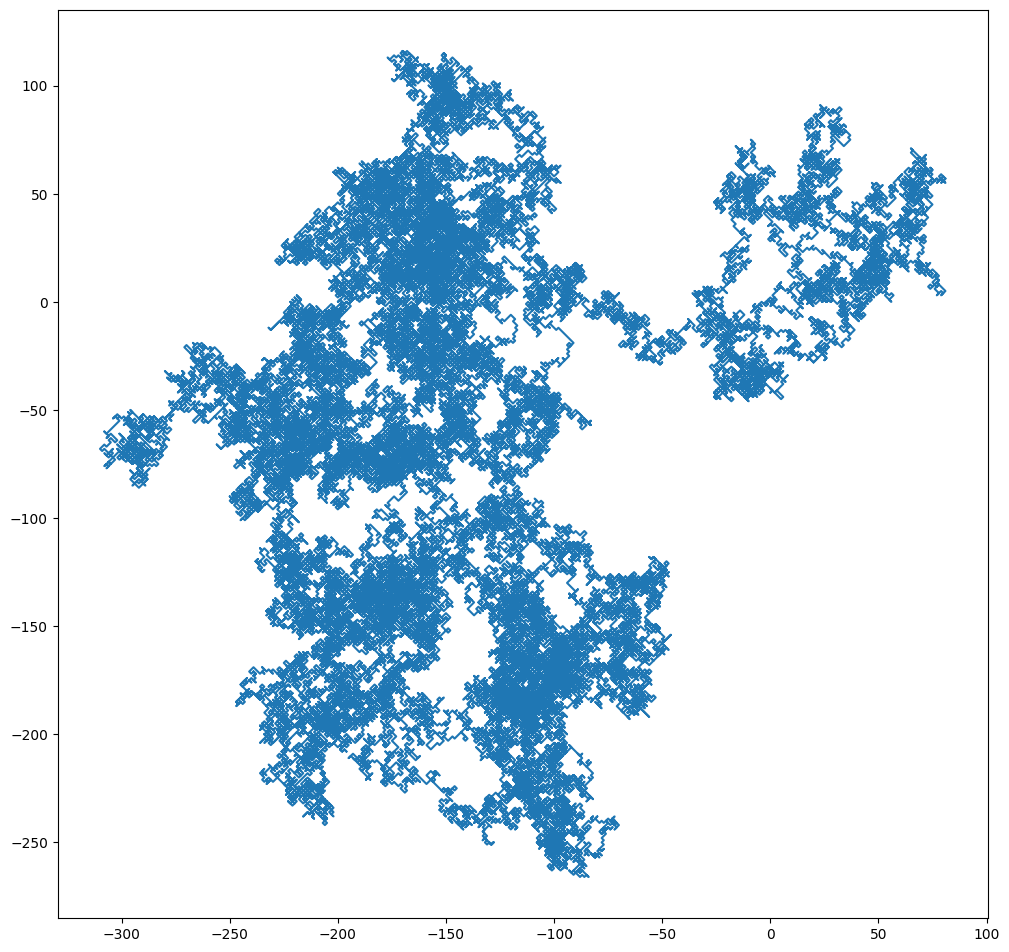

In [32]:
X = randomwalk(100000)
Y = randomwalk(100000)

plt.figure(figsize=(12,12))
plt.plot(X, Y)
plt.gca().set_aspect('equal')